# Chapter 2 - Accessing the Dataset

- 
This notebook shows how to

2.1 Understanding the Dataset

2.2 Subset the dataset

2.3 Interact with the dataset 

2.4 Interact with a table to query column descriptions

#### Assets 

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)


def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)


ModuleNotFoundError: No module named 'ome_zarr'

In [2]:
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")

#### Jupyter Notebook Help

The Jupyter Notebook team has lots of great [documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html) regarding the use of notebook. Check it out if you are interested in learning more.

#### Python Pandas Resources

Pandas is a python package that is regulary used throughout this workshop. You may have some extra questions or need some practice with this package. Check out the [tutorials](https://pandas.pydata.org/docs/getting_started/tutorials.html) and the [documentation](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) for more information.

## Chapter 2.1 Understanding the Dataset

### The hiPSC Single-Cell Image Dataset
Our dataset consists of 3D live-cell images of *normal human induced pluripotent stem cells (hiPSCs)*, which are a useful human cell model system. The dataset includes 25 cell lines representing fluorescently tagged major organelles, cellular structures, and compartments. Images of these cells were obtained in 3D using spinning-disk confocal microscopes and were further processed using deep learning-based segmentation. For the Purpose of this hackathon this Dataset has been filtered down to 214037 cells.

<img src="resources/hipsc_single_cell_image_dataset_summary.png"/>

As was described in the first chapter, the dataset consists of 25 different fluorescently tagged proteins that we use to visualize some of the majore organelles. Below you'll find a table that describes the gene, protein, a description, where in the cell the protein is generally locatated, as well the structure that the protein represents.

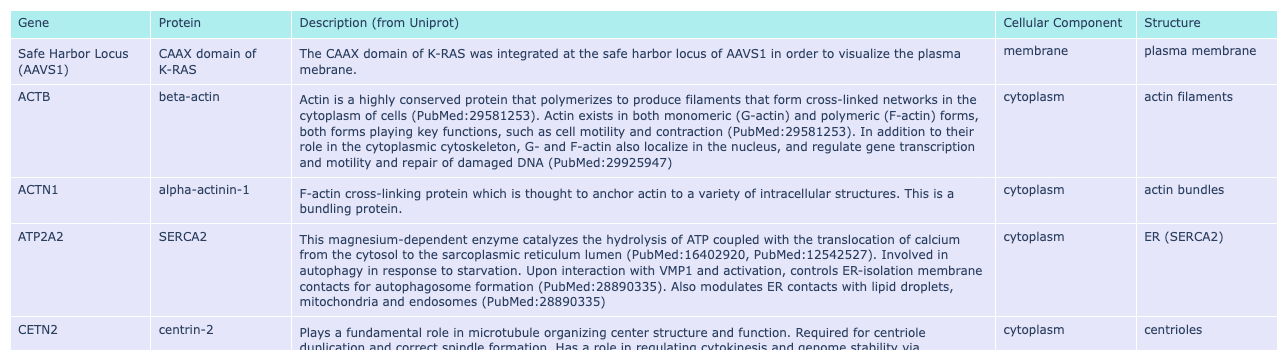

In [51]:
import plotly.graph_objects as go
cell_line_anno = pd.read_csv("resources/cell_line_annotation.txt",delimiter="\t")

fig_tab = go.Figure(
    data=[go.Table(
        columnwidth=[80,80,400,80,80],
        header=dict(values=list(cell_line_anno.columns),
            fill_color='paleturquoise',
            align = 'left'),
        cells=dict(values=[cell_line_anno.Gene,cell_line_anno.Protein,cell_line_anno['Description (from Uniprot)'],cell_line_anno['Cellular Component'],cell_line_anno.Structure],
                   fill_color='lavender',
                   align='left'))

    ]
)
fig_tab.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ),
)
fig_tab.show(renderer="jupyterlab")

### From FOVs to single-cell images
The hiPSC Single-Cell Image dataset consists of **215,081** single-cell images which were extracted from **18,100** fields of view (FOVs) of our cell colonies. Each row of the dataframe represents a cell, while the columns contain metadata, metrics, imaging data, etc...

In [7]:
# Breif Pre-Processing Description
# NAns for shapemodes
# outliers removed


In [ ]:
# Some Visualizations of the dataset

In [2]:
import plotly.express as px # need to get this to the top
df = pd.read_parquet("resources/hackathon_manifest_092022.parquet")
df.set_index(df['cell metadata']['CellId'].astype(int), inplace=True)
df_filt = df.copy()
df_filt.columns = df_filt.columns.droplevel(0)

The cell images came from over 18K FOVs and we can use the manifest to understand how many FOV's were captured per gene.

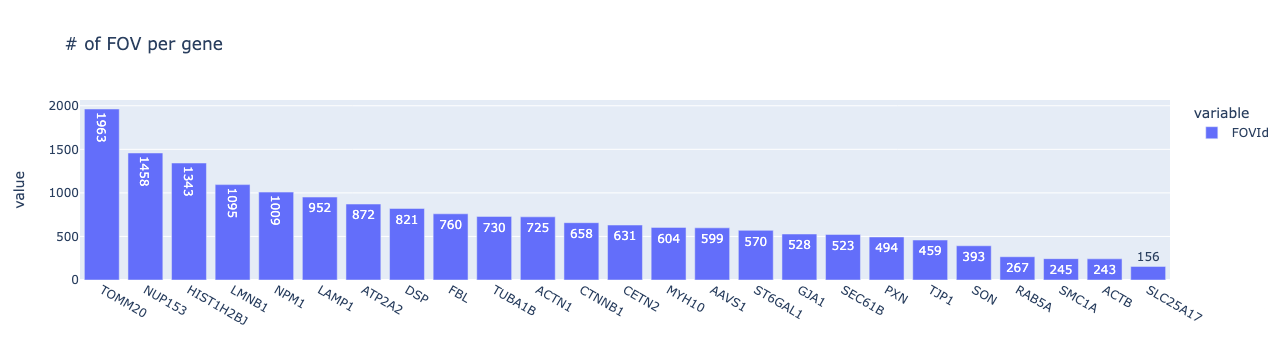

In [14]:
fig_fovstruc = px.bar(df_filt.groupby(['gene']).FOVId.nunique(),text_auto=True,title="# of FOV per gene")
fig_fovstruc.update_layout(xaxis=dict(categoryorder="total descending"),overwrite=True)
fig_fovstruc.show()

The number of FOVs isn't evenly distributed between the cell lines. In addition, the number of cells in an FOV varies based on position of the colony as well as the confluence of the wells. We can visualize the distribution of cells per FOV using a violin plot. We can parse the dataframe to calculate the number of cells per FOVId grouped by gene and then merge these counts into a new data frame for easy access later. Then we can visualize using a violin plot.

In [15]:
cells_per_fov = (
    df_filt.groupby('gene').FOVId
    .value_counts()
    .to_frame(name="cell_count_per_FOV")
    .reset_index()
    .set_index('FOVId')
    .merge(
        df_filt[['FOVId']]
        .drop_duplicates(subset=['FOVId'])
        .set_index('FOVId'),
        left_index=True,
        right_index=True
    )
    .reset_index()
)

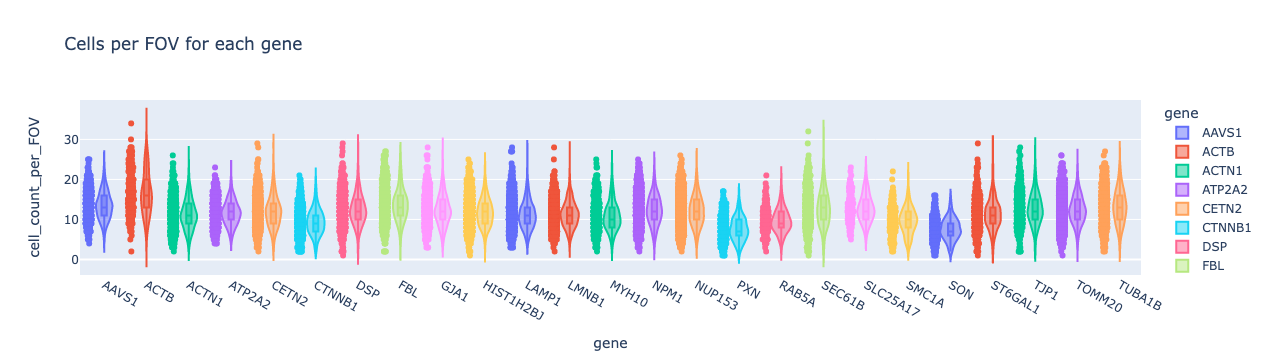

In [16]:
fig_cells_fov = px.violin(
    cells_per_fov,
    x=cells_per_fov.gene,
    y=cells_per_fov.cell_count_per_FOV,
    box=True,
    points='all',
    color=cells_per_fov.gene,
    hover_data=cells_per_fov,
    title="Cells per FOV for each gene"
)
fig_cells_fov.show()

Visualizing the data we can see that overall the distribution of the number of cells is consistent through the different cell lines. We can see that it FOV's generally contain between 2 and 20+ cells with a median around 14.  Though the FOV data is not included for the purposes of this task we can still visualize the FOVs as they are publically available data.  First we'll create a simple function that uses the FOVId to identify a Cell ID which we can use in our browser based cell viewer. You'll learn more ways to visualize the cells in the next chapters. But for now we can take a quick peek with the link below.

In [28]:
def generate_url(FOV_of_interest):
    cell_id = df_filt[df_filt['FOVId']==FOV_of_interest].CellId.tolist()[0]
    print(f"Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={int(cell_id)} and select the Full Field at the top of the screen")

We can hover the data from the violin plot above and select the highest point within the **ACTB** scatter plot and see that the **FOVID is 5785**. We'll use this to look at an FOV with 34 cells! 

In [29]:
FOV_of_interest = 5785 # CHANGE ME -  Enter FOV of interest in this case 5785 which comes from the max number of cells of of ACTB
generate_url(FOV_of_interest)

Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=439315 and select the Full Field at the top of the screen


The dataset consists of over 200K cells and based on the number distribution of FOVs we can assume that they are not evenly spraed across the 25 cell lines. We can visualize the number of cells per gene by further parsing the data frame.

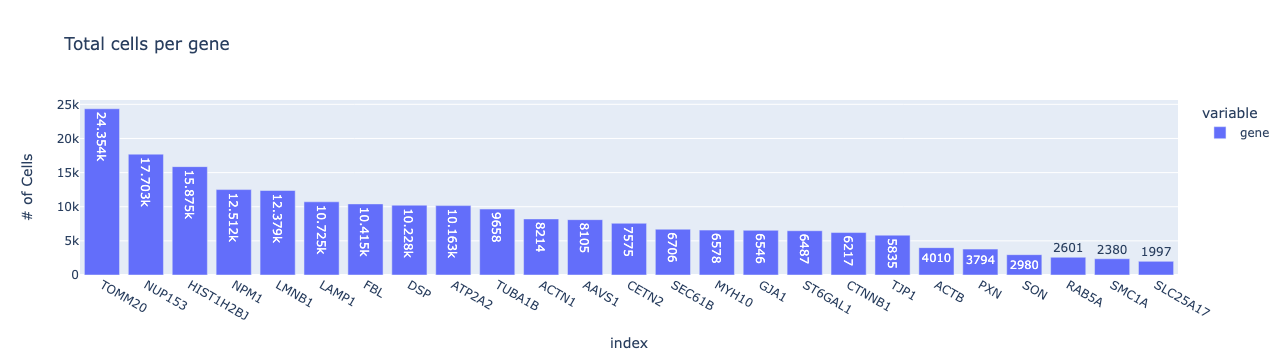

In [30]:
fig_total = px.bar(df_filt.gene.value_counts(),text_auto=True,title="Total cells per gene",labels=dict(value="# of Cells"))
fig_total.show()

## Chapter 2.2 Sub-Datasets

### Dataset Categories

The dataset columns have been broken down into 4 Categories [`cell metadata`, `field-of-view metadata`,`cell metric`,`cell images`]. These catagories are recognized as a secondary header. 

**cell metadata**: These 11 columns contain metadata pertaing to the cells, for example the cell cycle stage (cell_stage) and the tagged structure name (Structure).

**field-of-view metadata**: These 15 columns that annotate the field-of-view including: instrument used (instrumentId) plate confluency (meta_plate_confluency) and more.

**cell metric**: These 35 columns are metrics that pertain to the cell such as angle of rotation and bounding box information, structure volume, and nuclear volume.

**cell images**: These 12 columns give the paths to various types of images including max projections and center slices.

<img src="resources/Chapter2_columns.png"/>





### Creating Sub-Datasets

With the double headers of our data set we can quickly a d easily parse the data set select out specific categories of data. For example, if we wanted to see all the columns that pertained to the *cell metatdata* we would use the code below. 


In [49]:
df.xs('cell metadata', level=0,axis=1) # level=0 gets us on the first header and we want the columns so axis =1 

cell_stage     CellId Cellular Component  \
CellId                                               
230741          M4M5   230741.0          cytoplasm   
230745            M0   230745.0          cytoplasm   
230746            M0   230746.0          cytoplasm   
230748   M6M7_single   230748.0          cytoplasm   
230754            M0   230754.0          cytoplasm   
...              ...        ...                ...   
1003740           M0  1003740.0            nucleus   
1003741           M0  1003741.0            nucleus   
1003742           M0  1003742.0            nucleus   
1003743           M0  1003743.0            nucleus   
1003748           M0  1003748.0            nucleus   

                                Description (from Uniprot)  \
CellId                                                       
230741   Central component of the receptor complex resp...   
230745   Central component of the receptor complex resp...   
230746   Central component of the receptor complex resp...   
230748   Central component of the receptor complex resp...   
230754   Central component of the receptor complex resp...   
...                                                    ...   
1003740  Involved in chromosome cohesion during cell cy...   
1003741  Involved in chromosome cohesion during cell cy...   
1003742  Involved in chromosome cohesion during cell cy...   
1003743  Involved in chromosome cohesion during cell cy...   
1003748  Involved in chromosome cohesion during cell cy...   

        Draft mitotic state resolved  edge_flag Protein     Structure    gene  \
CellId                                                                          
230741                          None        0.0   Tom20  mitochondria  TOMM20   
230745                          None        0.0   Tom20  mitochondria  TOMM20   
230746                            M0        0.0   Tom20  mitochondria  TOMM20   
230748                         M6/M7        0.0   Tom20  mitochondria  TOMM20   
230754                          None        0.0   Tom20  mitochondria  TOMM20   
...                              ...        ...     ...           ...     ...   
1003740                         None        0.0  SMC-1A      cohesins   SMC1A   
1003741                         None        0.0  SMC-1A      cohesins   SMC1A   
1003742                         None        0.0  SMC-1A      cohesins   SMC1A   
1003743                         None        0.0  SMC-1A      cohesins   SMC1A   
1003748                         None        0.0  SMC-1A      cohesins   SMC1A   

         this_cell_index  this_cell_nbr_complete  
CellId                                            
230741               1.0                     1.0  
230745               5.0                     1.0  
230746               6.0                     0.0  
230748               8.0                     0.0  
230754              14.0                     0.0  
...                  ...                     ...  
1003740             13.0                     0.0  
1003741             14.0                     0.0  
1003742             15.0                     0.0  
1003743             16.0                     0.0  
1003748             21.0                     0.0  

[214037 rows x 11 columns]

The above code can be changed to any of the four categories [`cell metadata`, `field-of-view metadata`,`cell metric`,`cell images`] to quickly get the corresponding information.

# By Columns

Lets get a specific list of columns. angle and structure
# visual angle by structure

In [3]:
lst = ['angle','gene']

In [13]:
(sub_angle_struc['angle']<0)

CellId
230741     False
230745     False
230746     False
230748     False
230754     False
           ...  
1003740    False
1003741    False
1003742    False
1003743    False
1003748    False
Name: angle, Length: 214037, dtype: bool

In [5]:
sub_angle_struc = df_filt[lst]
# get the mean
sub_angle_struc['angle'] = sub_angle_struc['angle'].abs()

/tmp/ipykernel_1478/839303185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_angle_struc['angle'] = sub_angle_struc['angle'].abs()


In [117]:

df_mean = sub_angle_struc.groupby("gene").abs.mean()

AttributeError: 'DataFrameGroupBy' object has no attribute 'abs'

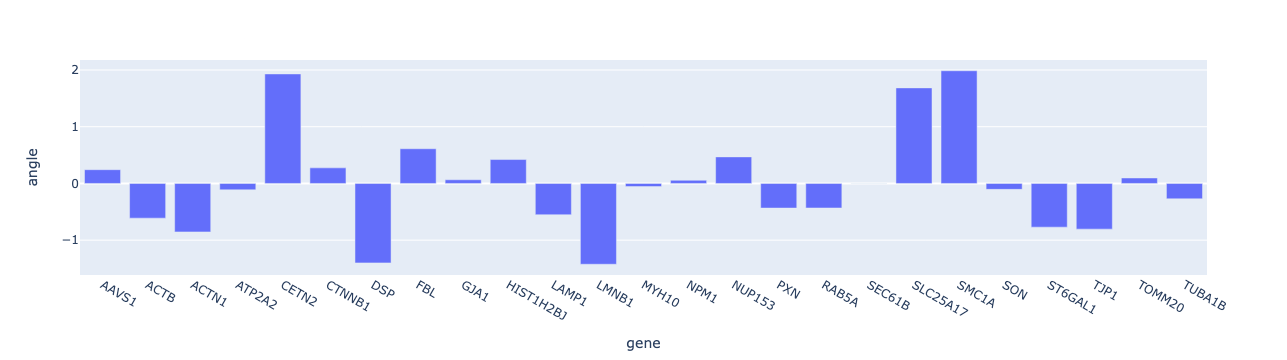

In [115]:
px.bar(df_mean,x=df_mean.index, y='angle')

## Chapter 2.3 Interacting with the Dataset

In [ ]:
# Querying

In [6]:
# Grouping

## Chapter 2.4 Column Descriptions


The dataset contains 78 columns with important metrics which you may want to incorporate during the challenge. In this section we'll create a tiny dash app that runs within the notebook in order to display an interactive table of the columns and their descriptions. **The table is searchable** lending itself to more efficient querying.

In [8]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
JupyterDash.infer_jupyter_proxy_config()

ModuleNotFoundError: No module named 'jupyter_dash'

In [ ]:
col_df = pd.read_csv("resources/colname_test.csv",delimiter=":",header=None)
col_df.columns = ["column name","description"]

In [5]:
# Some sort of Look up method built in for looking at column definitions 
from dash import dash_table
app = JupyterDash(__name__)
server = app.server

app.layout = dash_table.DataTable(
    col_df.to_dict('records'), 
    [{"name": i, "id": i} for i in col_df.columns],
    style_data={
        'whiteSpace':'normal',
        'height': 'auto',
        'lineHeight':'15px',
        'backgroundColor': 'rgb(50,50,50)',
        'color': 'white',
    },
    style_header={
        'backgroundColor':'rgb(30,30,30)',
        'color':'white'
    },  
    style_cell={
        'textAlign':'left'
    },
    filter_action="native",
)


In [ ]:
app.run_server(mode="inline", port=8588,) # This runs on a specified port. Either enable port forwarding on your maching. #TODO work with Gui to enable this directly from the app rather than port forwarding. 